In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/processed/processed_data.csv')
X = df.drop(columns=['Risk_Label'])  # Features
y = df['Risk_Label']  # Target variable

# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize the models
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)


In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop non-relevant columns
df_cleaned = df.drop(columns=['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'TransactionStartTime'])

# Separate features and target variable
X = df_cleaned.drop(columns=['Risk_Label'])
y = df_cleaned['Risk_Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps: One-Hot Encoding for categorical features with handle_unknown='ignore'
categorical_cols = X.select_dtypes(include=['object']).columns

# Use a pipeline for both preprocessing and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define models
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Train the Logistic Regression model
log_reg.fit(X_train, y_train)

# Train the Random Forest model
rf.fit(X_train, y_train)

# Evaluate both models
log_reg_pred = log_reg.predict(X_test)
rf_pred = rf.predict(X_test)

# Print classification report for both models
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17342
           1       1.00      0.90      0.95      1791

    accuracy                           0.99     19133
   macro avg       0.99      0.95      0.97     19133
weighted avg       0.99      0.99      0.99     19133

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17342
           1       1.00      0.93      0.96      1791

    accuracy                           0.99     19133
   macro avg       1.00      0.97      0.98     19133
weighted avg       0.99      0.99      0.99     19133



In [11]:
from sklearn.preprocessing import StandardScaler

log_reg = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId']),
            ('num', StandardScaler(), ['Amount', 'Value'])  # Add numerical scaling
        ])),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define preprocessing for both models
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId']),
        ('num', StandardScaler(), ['Amount', 'Value'])  # Standard scaling for numerical features
    ]
)

# Define Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define Logistic Regression pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Define hyperparameters for Random Forest
rf_params = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Define hyperparameters for Logistic Regression
log_reg_params = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['liblinear', 'saga']  # Solvers compatible with small datasets
}

# Use RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Use GridSearchCV for Logistic Regression
log_reg_grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the models
rf_random_search.fit(X_train, y_train)
log_reg_grid_search.fit(X_train, y_train)

# Get the best estimators
rf_best = rf_random_search.best_estimator_
log_reg_best = log_reg_grid_search.best_estimator_

# Output the best parameters and scores
print(f"Best params for Random Forest: {rf_random_search.best_params_}")
print(f"Best cross-validated accuracy for Random Forest: {rf_random_search.best_score_:.4f}")
print(f"Best params for Logistic Regression: {log_reg_grid_search.best_params_}")
print(f"Best cross-validated accuracy for Logistic Regression: {log_reg_grid_search.best_score_:.4f}")


Best params for Random Forest: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}
Best cross-validated accuracy for Random Forest: 0.9785
Best params for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Best cross-validated accuracy for Logistic Regression: 0.9962


In [34]:
# Get the best Logistic Regression model
log_reg_best = log_reg_grid_search.best_estimator_

# Predict on the test set using the best Logistic Regression model
log_reg_pred = log_reg_best.predict(X_test)

# Predict on the test set using the best Random Forest model
rf_best = rf_random_search.best_estimator_
rf_pred = rf_best.predict(X_test)

# Evaluate the models
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression Metrics
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_precision = precision_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred)
log_reg_roc_auc = roc_auc_score(y_test, log_reg_best.predict_proba(X_test)[:, 1])  # Use probabilities for ROC-AUC

# Random Forest Metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1])  # Use probabilities for ROC-AUC

# Print evaluation metrics
print(f"Logistic Regression - Accuracy: {log_reg_accuracy:.2f}, Precision: {log_reg_precision:.2f}, Recall: {log_reg_recall:.2f}, F1: {log_reg_f1:.2f}, ROC-AUC: {log_reg_roc_auc:.2f}")
print(f"Random Forest - Accuracy: {rf_accuracy:.2f}, Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}, F1: {rf_f1:.2f}, ROC-AUC: {rf_roc_auc:.2f}")

# Optional: Print detailed classification reports
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, log_reg_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred))


Logistic Regression - Accuracy: 1.00, Precision: 1.00, Recall: 0.97, F1: 0.99, ROC-AUC: 1.00
Random Forest - Accuracy: 0.98, Precision: 0.96, Recall: 0.84, F1: 0.90, ROC-AUC: 0.99

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17342
           1       1.00      0.97      0.99      1791

    accuracy                           1.00     19133
   macro avg       1.00      0.99      0.99     19133
weighted avg       1.00      1.00      1.00     19133


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     17342
           1       0.96      0.84      0.90      1791

    accuracy                           0.98     19133
   macro avg       0.97      0.92      0.94     19133
weighted avg       0.98      0.98      0.98     19133



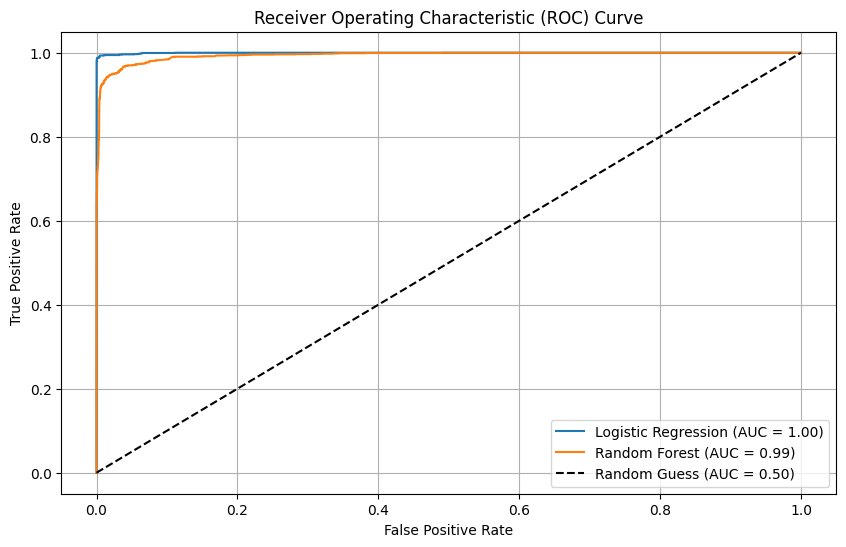

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
log_reg_proba = log_reg_best.predict_proba(X_test)[:, 1]
rf_proba = rf_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

# Compute ROC AUC
log_reg_roc_auc = roc_auc_score(y_test, log_reg_proba)
rf_roc_auc = roc_auc_score(y_test, rf_proba)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {log_reg_roc_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
